In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [25]:
DATA_PATH = "train.csv.zip"
OUT_DIR = Path("exports")
OUT_DIR.mkdir(exist_ok=True, parents=True)
pd.set_option('display.max_columns', None)

In [5]:
print(df.head())
print(df.describe())
print(list(df.columns))
print(df.shape)
print(df.dtypes)
print(df.isna().sum())



   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

In [6]:
if 'Postal Code' in df.columns and df['Postal Code'].isna().any():
    df['Postal Code'] = df['Postal Code'].fillna(df['Postal Code'].mode()[0])

In [7]:
before = df['Postal Code'].isna().sum()
df['Postal Code'] = df['Postal Code'].fillna(df['Postal Code'].mode()[0])
after = df['Postal Code'].isna().sum()

print("Missing before:", before)
print("Missing after:", after)


Missing before: 0
Missing after: 0


In [8]:
for col in ['Order Date', 'Ship Date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.to_period('M').astype(str)

In [9]:
print(df[['Order Date', 'Ship Date', 'Year', 'Month']].head())


  Order Date  Ship Date  Year    Month
0 2017-11-08 2017-11-11  2017  2017-11
1 2017-11-08 2017-11-11  2017  2017-11
2 2017-06-12 2017-06-16  2017  2017-06
3 2016-10-11 2016-10-18  2016  2016-10
4 2016-10-11 2016-10-18  2016  2016-10


In [10]:
def stable_seed_from_string(s: str) -> int:
    return abs(hash(s)) % (2**32 - 1)

category_qty_ranges = {
    'Furniture': (1, 4),
    'Office Supplies': (1, 12),
    'Technology': (1, 6)
}

quantities, discounts, base_margins = [], [], []

for _, row in df.iterrows():
    cat = row.get('Category', 'Office Supplies')
    low, high = category_qty_ranges.get(cat, (1, 6))
    seed = stable_seed_from_string(str(row.get('Product ID', 'NA')))
    rng = np.random.default_rng(seed)

    qty = int(rng.integers(low, high + 1))
    quantities.append(qty)

    if cat == 'Furniture':
        disc = float(rng.uniform(0.00, 0.30))
        margin = 0.15
    elif cat == 'Technology':
        disc = float(rng.uniform(0.00, 0.40))
        margin = 0.20
    else:  
        disc = float(rng.uniform(0.00, 0.50))
        margin = 0.25

    discounts.append(round(disc, 2))
    base_margins.append(margin)

df['Quantity']    = quantities
df['Discount']    = discounts
df['Base_Margin'] = base_margins

# Financials
# Treat Sales as list price; Revenue = Sales - (Sales * Discount)
df['Discount_Amount'] = df['Sales'] * df['Discount']
df['Revenue']         = df['Sales'] - df['Discount_Amount']
df['Profit']          = df['Revenue'] * df['Base_Margin']

print("\nEngineered columns preview:\n", df[['Sales','Quantity','Discount','Revenue','Profit']].head())



Engineered columns preview:
       Sales  Quantity  Discount    Revenue      Profit
0  261.9600         4      0.23  201.70920   30.256380
1  731.9400         2      0.05  695.34300  104.301450
2   14.6200        11      0.21   11.54980    2.887450
3  957.5775         3      0.10  861.81975  129.272963
4   22.3680         6      0.50   11.18400    2.796000


In [11]:
def sum_by(col):
    if col in df.columns:
        return (df.groupby(col, as_index=False)['Revenue']
                  .sum()
                  .sort_values('Revenue', ascending=False))
    else:
        return pd.DataFrame(columns=[col, 'Revenue'])

region_sales   = sum_by('Region')
category_sales = sum_by('Category')
segment_sales  = sum_by('Segment')

top_products = (df.groupby('Product Name', as_index=False)['Revenue']
                  .sum()
                  .sort_values('Revenue', ascending=False)
                  .head(10))

monthly_sales = (df.groupby('Month', as_index=False)['Revenue']
                   .sum())

In [12]:
if 'Category' in df.columns and 'Region' in df.columns:
    heatmap_pivot = (df.pivot_table(values='Revenue',
                                    index='Category',
                                    columns='Region',
                                    aggfunc='sum')
                       .fillna(0))
else:
    heatmap_pivot = pd.DataFrame()

In [13]:
print("\nRegion Sales:\n", region_sales.head())
print("\nCategory Sales:\n", category_sales.head())
print("\nSegment Sales:\n", segment_sales.head())
print("\nTop Products:\n", top_products)
print("\nMonthly Sales (head):\n", monthly_sales.head())


Region Sales:
     Region        Revenue
3     West  573232.629130
1     East  542248.660330
0  Central  393956.230144
2    South  311890.891790

Category Sales:
           Category        Revenue
2       Technology  660914.774740
0        Furniture  622097.218604
1  Office Supplies  538316.418050

Segment Sales:
        Segment        Revenue
0     Consumer  926567.502595
1    Corporate  552535.537584
2  Home Office  342225.371215

Top Products:
                                            Product Name      Revenue
404               Canon imageCLASS 2200 Advanced Copier  46815.86624
649   Fellowes PB500 Electric Punch Plastic Comb Bin...  26355.24864
785        HON 5400 Series Task Chairs for Big and Tall  18152.57808
786   HP Designjet T520 Inkjet Large Format Printer ...  17456.15025
1042  Martin Yale Chadless Opener Electric Letter Op...  16656.20000
682           GBC DocuBind P400 Electric Binding System  16527.86256
444   Cisco TelePresence System EX90 Videoconferenci...  14488.6

In [15]:
#visualization
plt.rcParams['figure.figsize'] = (8, 4)


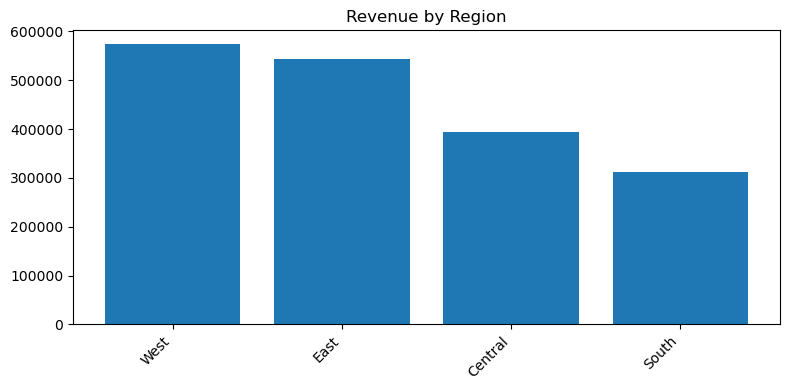

In [32]:
# Revenue by Region
plt.figure(figsize=(8,4))
plt.bar(region_sales['Region'], region_sales['Revenue'])
plt.title('Revenue by Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig(f"{EXPORT_DIR}/revenue_by_region.png")
plt.close()

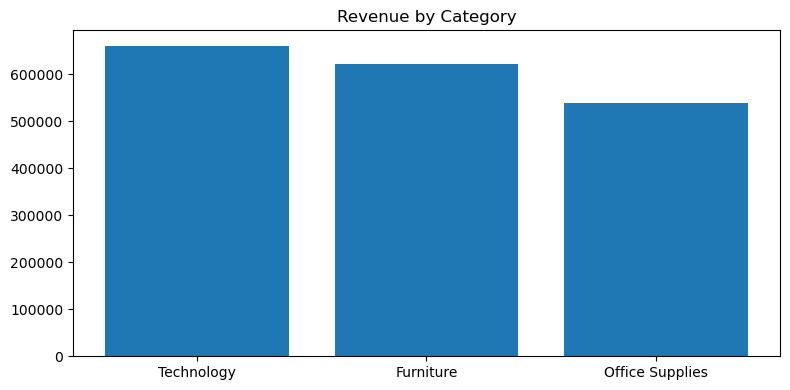

In [33]:
# Revenue by Category
plt.figure(figsize=(8,4))
plt.bar(category_sales['Category'], category_sales['Revenue'])
plt.title('Revenue by Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
plt.savefig(f"{EXPORT_DIR}/revenue_by_category.png")
plt.close()

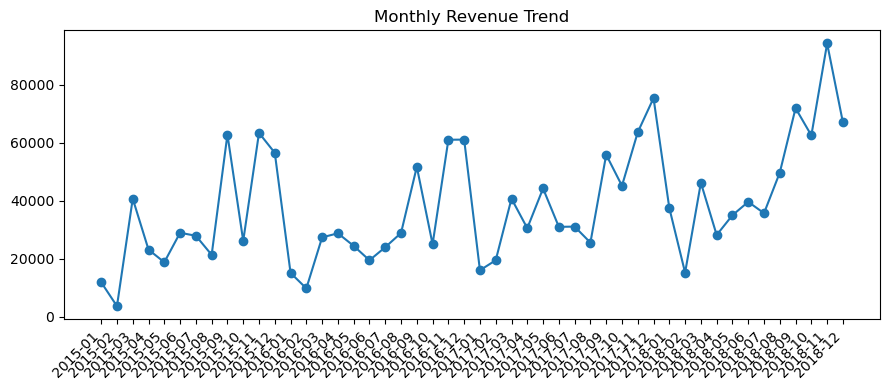

In [36]:
# Line: Monthly Revenue Trend 
plt.figure(figsize=(9,4))
plt.plot(monthly_sales['Month'], monthly_sales['Revenue'], marker='o')
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig(f"{EXPORT_DIR}/monthly_revenue_trend.png")
plt.close()

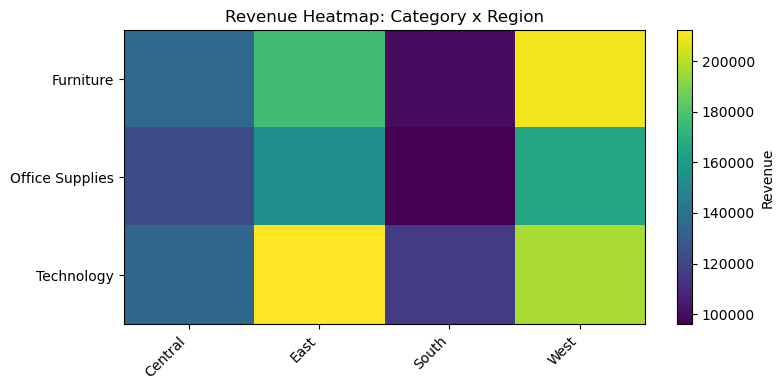

In [34]:
# Heatmap
plt.figure(figsize=(8,4))
plt.imshow(heatmap_pivot.values, aspect='auto')
plt.title('Revenue Heatmap: Category x Region')
plt.yticks(range(len(heatmap_pivot.index)), heatmap_pivot.index)
plt.xticks(range(len(heatmap_pivot.columns)), heatmap_pivot.columns, rotation=45, ha='right')
plt.colorbar(label='Revenue')
plt.tight_layout()
plt.show()
plt.savefig(f"{EXPORT_DIR}/revenue_heatmap.png")
plt.close()

In [20]:
#kpi summary
kpis = {
    'Total Revenue': [df['Revenue'].sum()],
    'Total Profit (Estimated)': [df['Profit'].sum()],
    'Orders': [df['Order ID'].nunique()] if 'Order ID' in df.columns else [np.nan],
    'Customers': [df['Customer ID'].nunique()] if 'Customer ID' in df.columns else [np.nan],
    'Products': [df['Product ID'].nunique()] if 'Product ID' in df.columns else [np.nan],
    'Start Date': [df['Order Date'].min()],
    'End Date': [df['Order Date'].max()],
}
kpi_df = pd.DataFrame(kpis)

In [21]:
#save csv
kpi_df.to_csv(OUT_DIR / "kpi_summary.csv", index=False)
region_sales.to_csv(OUT_DIR / "sales_by_region.csv", index=False)
category_sales.to_csv(OUT_DIR / "sales_by_category.csv", index=False)
segment_sales.to_csv(OUT_DIR / "sales_by_segment.csv", index=False)
top_products.to_csv(OUT_DIR / "top_10_products.csv", index=False)
monthly_sales.to_csv(OUT_DIR / "monthly_revenue.csv", index=False)


In [23]:
df.to_csv(OUT_DIR / "train.csv.zip", index=False)

print("\n=== Exports written to ./exports ===")
print("- kpi_summary.csv")
print("- sales_by_region.csv")
print("- sales_by_category.csv")
print("- sales_by_segment.csv")
print("- top_10_products.csv")
print("- monthly_revenue.csv")
print("- enhanced_sales_dataset.csv")
print("- rev_by_region.png, rev_by_category.png, monthly_revenue_trend.png, revenue_heatmap.png (if applicable)")


=== Exports written to ./exports ===
- kpi_summary.csv
- sales_by_region.csv
- sales_by_category.csv
- sales_by_segment.csv
- top_10_products.csv
- monthly_revenue.csv
- enhanced_sales_dataset.csv
- rev_by_region.png, rev_by_category.png, monthly_revenue_trend.png, revenue_heatmap.png (if applicable)


In [27]:
import os

EXPORT_DIR = "analysis_exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

region_sales.to_csv(f"{EXPORT_DIR}/region_sales.csv", index=False)
category_sales.to_csv(f"{EXPORT_DIR}/category_sales.csv", index=False)
segment_sales.to_csv(f"{EXPORT_DIR}/segment_sales.csv", index=False)
top_products.to_csv(f"{EXPORT_DIR}/top_products.csv", index=False)
monthly_sales.to_csv(f"{EXPORT_DIR}/monthly_sales.csv", index=False)
df.to_csv(f"{EXPORT_DIR}/enhanced_dataset.csv", index=False)
kpi_df.to_csv(f"{EXPORT_DIR}/kpi_summary.csv", index=False)

print("✅ CSV export completed! Files saved inside /analysis_exports")

✅ CSV export completed! Files saved inside /analysis_exports


In [37]:
plt.savefig(f"{EXPORT_DIR}/revenue_by_region.png")
plt.savefig(f"{EXPORT_DIR}/revenue_by_category.png")
plt.savefig(f"{EXPORT_DIR}/monthly_revenue_trend.png")
plt.savefig(f"{EXPORT_DIR}/revenue_heatmap.png")

print("✅ Charts saved as PNG inside /analysis_exports")


✅ Charts saved as PNG inside /analysis_exports


<Figure size 800x400 with 0 Axes>

In [39]:
import os
print(os.getcwd())


C:\Users\shyam
